In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import head
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pdb
import warnings
warnings.filterwarnings("ignore")

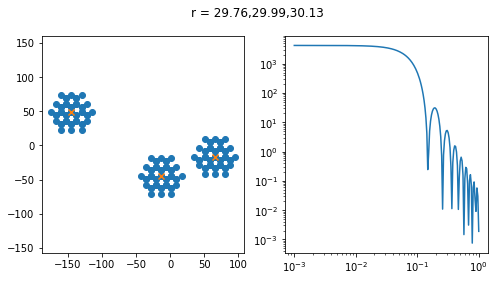

In [3]:
"""Generate a target spectrum
We simulate a target spectrum with a fixed number of spehre's with 
radii sampled from a narrow lognormal distribution
"""
sim = head.Emulator()
fig, axs = plt.subplots(1,2,figsize=(8,4))
R_mu = 1
R_sigma = 1e-2
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)
sim.plot_structure2d(ax=axs[0])

q, st = sim.get_saxs()
axs[1].loglog(q, st)
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.step*sim.radii))
plt.show()

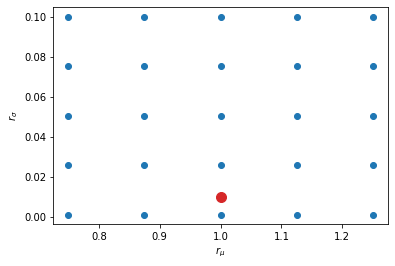

In [4]:
"""
create a search space as a grid of mu and sigma values of lognormal radii distribution

"""
NUM = 5
X = np.linspace(0.75,1.25, num=NUM) 
Y = np.linspace(1e-3,1e-1, num=NUM)
grid = head.Grid(X,Y)
fig, ax = plt.subplots()
ax.scatter(grid.points[:,0], grid.points[:,1], label='Grid points')
ax.scatter(R_mu, R_sigma, s=100, color='tab:red', label='Target')
ax.set_xlabel(r'$r_{\mu}$')
ax.set_ylabel(r'$r_{\sigma}$')
plt.show()

In [5]:
# define a model for the loss function we would like to optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

kernel = 1.0 * Matern(length_scale=0.2, nu=1.5)
model = GaussianProcessRegressor(kernel=kernel)

In [6]:
query_strategy = head.thompson_sampling

In [7]:
"""Implement a evaluate_input function
This function takes points in the input space and return spectra at those locations
"""
def evaluate_inputs(Xb):
    Sb = []
    for xbi in Xb:
        sim.make_structure(r_mu=xbi[0],r_sigma=xbi[1])
        q, pq = sim.get_saxs()
        Sb.append(pq)
    return Sb

In [8]:
from head.metrics import euclidean_dist

def oracle(si,st):
    """Scoring function between two spectra
    Given two spectra in si, st compute a score between them.
    Note that here si, st are represented using the class `head.UVVis`.
    If you are using arrays, you'd have to make necessary transformations.
    """
    return euclidean_dist(np.log10(si),np.log10(st))

In [9]:
experiment = {}

In [10]:
from modAL.models import BayesianOptimizer

design = head.ExampleRunner(grid)
design.set_params(**{'oracle':oracle,
                     'st':st
                    }
                 )

n_iterations = 2 # total number of iterations to run the batch search for
batch_size = 5 # batch size requested in each query
n_initial = 2 # number of intitial samples to select randomly

# initiate the optimization by randomly sampling `n_initial` samples
X0 = design.request_batch(n_initial, is_init=True)
print('Requested batch evaluation for the following: ', X0,'\n')

# You would eventually replace this function using the `get_OT2batch` at appropriate places
S0 = evaluate_inputs(X0)
print('Obtained %d spectra as a list'%len(S0),'\n')
Y0 = design.evaluate_batch(S0)
print('Obtained score values for the current batch are: ',Y0,'\n')

experiment.update({0:(X0,S0,Y0)})

# create a optimizer module with the obtained initial samples from above
optimizer = BayesianOptimizer(
    estimator=model,
    query_strategy=query_strategy,
    X_training = X0,
    y_training = Y0
)

design.set_params(**{'optimizer':optimizer})

for n_iter in range(n_iterations):
    Xb = design.request_batch(batch_size, is_init=False)
    print('Requested batch evaluation for the following:\n', Xb,'\n')
    Sb = evaluate_inputs(Xb)
    print('Obtained %d spectra as a list'%len(Sb),'\n')
    Yb = design.evaluate_batch(Sb)
    print('Obtained score values for the %d batch are: '%n_iter,Yb,'\n')
    experiment.update({n_iter+1:(Xb,Sb,Yb)})
    design.optimizer.teach(Xb, Yb)

Requested batch evaluation for the following:  [[1.125e+00 2.575e-02]
 [1.250e+00 1.000e-03]] 

Obtained 2 spectra as a list 

1
Obtained score values for the current batch are:  [-8.58505701 -9.38562458] 

Requested batch evaluation for the following:
 [[1.125e+00 1.000e-01]
 [7.500e-01 1.000e-03]
 [7.500e-01 1.000e-01]
 [7.500e-01 1.000e-03]
 [8.750e-01 1.000e-03]] 

Obtained 5 spectra as a list 

2
Obtained score values for the 0 batch are:  [-6.24273092 -9.37561221 -8.01300477 -9.08724574 -9.21390099] 

Requested batch evaluation for the following:
 [[1.125 0.1  ]
 [1.    0.1  ]
 [1.    0.1  ]
 [1.    0.1  ]
 [1.125 0.1  ]] 

Obtained 5 spectra as a list 

3
Obtained score values for the 1 batch are:  [-6.54340302 -4.88020927 -4.23550963 -5.00308134 -9.73590402] 



Optimized values r_mu = 1.00 , r_sigma = 0.10


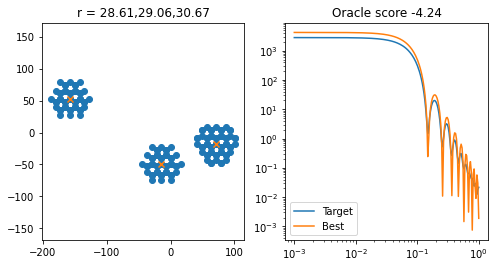

In [11]:
X_max, y_max = design.optimizer.get_max()
print('Optimized values r_mu = %.2f , r_sigma = %.2f'%(X_max[0],X_max[1]))

fig, axs = plt.subplots(1,2,figsize=(8,4))
sim.make_structure(r_mu=X_max[0],r_sigma=X_max[1])
sim.plot_structure2d(ax=axs[0])
axs[0].set_title('r = '+','.join('%.2f'%i for i in sim.step*sim.radii))

sbest = design.get_best_spectrum(X_max)
axs[1].loglog(q,sbest)
axs[1].loglog(q, st)
axs[1].set_title('Oracle score {:.2f}'.format(float(y_max)))
axs[1].legend(['Target','Best'])
plt.show()

In [12]:
import pickle

with open('../data/expt.pkl', 'wb') as handle:
    pickle.dump(experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/expt.pkl', 'rb') as handle:
    b = pickle.load(handle)
    
assert len(b)==n_iterations+1 ,"expt.pkl length is not correct"